# MSA 2024 Phase 2 - Part 3

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical 

Contents:
1. Load and split preprocessed data
2. Use CNN for train and test a model
3. Evaluate the model 
4. Summary

### 1. Load, split and preprocessing data

In [18]:
# Prepare the training and testing image sets.
train_dir = '/kaggle/input/nzmsa-2024/cifar10_images/train'
test_dir = '/kaggle/input/nzmsa-2024/cifar10_images/test'

In [19]:
# Define a function to load training image sets from Kaggle into np arrays, with ids, images and its lables.
def loadTrain(root_dir, csv_file):
    ids = [] # array of ids
    images = [] # array of images 
    labels = [] # array of corresponding labels
    annotations = np.genfromtxt(csv_file, delimiter=',', names=True)
    for idx in range(len(annotations)):
        # Loop through every images, record its ids, images and labels.
        img_id = int(annotations['id'][idx])
        img_name = os.path.join(root_dir, f"image_{img_id}.png")
        image = np.array(Image.open(img_name).convert("RGB"))
        label = int(annotations['label'][idx])

        ids.append(img_id)
        images.append(image)
        labels.append(label)
    return np.array(ids), np.array(images), np.array(labels)

In [20]:
# Define a function to load testing image sets from Kaggle into np arrays, with ids, images.
def loadTest(root_dir):
    ids = []
    images = []
    for idx in range(len(os.listdir(root_dir))):
        img_name = os.path.join(root_dir, f"image_{idx}.png")
        image = np.array(Image.open(img_name).convert("RGB"))

        ids.append(idx)
        images.append(image)
    return np.array(ids), np.array(images)

In [21]:
# Load training, testing data and the training label provided in train.csv.
train_csv = '/kaggle/input/nzmsa-2024/train.csv'
id_train, X_train, y_train = loadTrain(train_dir, train_csv)
id_test, X_test = loadTest(test_dir)

print('x_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')



x_train shape: (50000, 32, 32, 3)
y_train shape: (50000,)
50000 train samples
5000 test samples


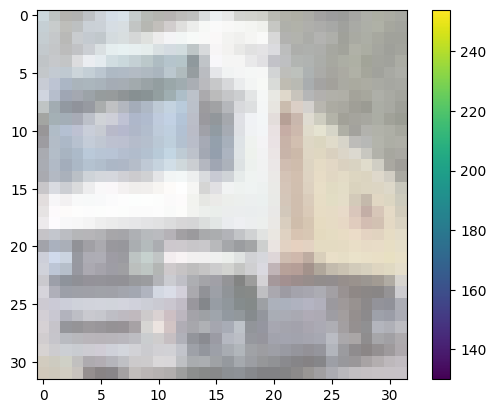

In [22]:
# Display the image with index 1.
plt.figure()
plt.imshow(X_train[1])
plt.colorbar()

In [23]:
# Normalize the data to fit in to CNN model.
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert training labels to one-hot encoded vectors, since the images have 10 classes.
y_train = to_categorical(y_train, 10)

Normalizing the data by dividing values by 255, will normalizing the data between 0-1.

Since our images set has 10 classes, so we can use one-hot encoded to label it. 

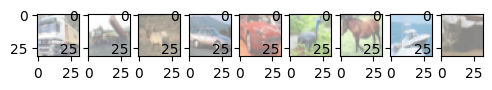

In [24]:
# Visualizing the 10 images from index 1-10.
for i in range(1,10):
    plt.subplot(1, 10, i)
    plt.imshow(X_train[i])

### 2. Use CNN for train and test a model

In this section, we build a CNN model to train and test. 

1. First we initialised a sequential model, and get the input layer from the images sets.
2. Then the we build feature extraction such as Convolutional Layers, Activation Functions and Pooling Layers.
3. We will also using Normalization and Dropout to prevent overfitting and improve the generalization of the model.
4. Then we flatten and dense which generated a final output layer.
5. We also add data augmentation to reduce overfitting.
6. Lastly, compile the model and then use our model to fit and predict.
7. A submission.csv contains ids, and labels, is produced for Kaggle Competition.

In total, We will have 6 CNN layers, 3 maxpool layer, 7 Batch Normalization, 4 Dropout, 1 Flatten and 2 Dense.

In [28]:
# Model initialization.
model = tf.keras.Sequential()
     
    
# Define the CNN model.

# Conv2D: These layers apply various filters to the input image to create feature maps that represent different aspects of the input image.
# ReLU: is applied to introduce non-linearity.
# BatchNormalization: Normalizing the input layer by adjusting and scaling the activations
# MaxPooling2D: Pooling reduces the spatial dimensions, retaining the most important information while reducing computational complexity.
# Dropout: Randomly dropping some neurons during the training process, to learn new features from the input data.

model.add(Conv2D(64,(3,3),input_shape=(32,32,3),activation='relu',padding='same'))  
model.add(BatchNormalization()) 
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization()) 
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3)) 

model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Flatten: The 2D feature maps are flattened into a 1D vector.
# Dense: These layers take the flattened vector and learn to classify the image based on the features extracted by the convolutional layers.

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10,  activation="softmax"))



# Complile the model.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# Add data augmentation
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, rotation_range=10, validation_split=0.2)
train_generator = data_generator.flow(X_train, y_train, subset='training',shuffle=True,batch_size=32) 
validation_gen = data_generator.flow(X_train, y_train, subset='validation', shuffle=True,batch_size=32)

#Step_size_train=train_generator.n//32
#Step_size_valid=validation_gen.n//32
    
    
# Train the model.
History = model.fit(train_generator, epochs=10, batch_size=32, validation_data=validation_gen)


# Make predictions.
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)


# Prepare your submission file.
submission = np.column_stack((id_test, predicted_labels))
np.savetxt('submission.csv', submission, delimiter=',', header='id, Label', comments='', fmt='%d')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 443s 349ms/step - accuracy: 0.2963 - loss: 2.2107 - val_accuracy: 0.1824 - val_loss: 3.9988
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 435s 348ms/step - accuracy: 0.5205 - loss: 1.3430 - val_accuracy: 0.4221 - val_loss: 1.8579
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 436s 349ms/step - accuracy: 0.6160 - loss: 1.0862 - val_accuracy: 0.5056 - val_loss: 1.5706
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 433s 346ms/step - accuracy: 0.6663 - loss: 0.9515 - val_accuracy: 0.4006 - val_loss: 2.0603
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 443s 347ms/step - accuracy: 0.6912 - loss: 0.8848 - val_accuracy: 0.6599 - val_loss: 0.9561
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 447s 358ms/step - accuracy: 0.7200 - loss: 0.8124 - val_accuracy: 0.4680 - val_loss: 1.8478
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 434s 347ms/step - accuracy: 0.7336 - loss: 0.7636 - val_accuracy: 0.5212 - val_loss: 1.4656
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 436s 349ms/step - accuracy: 0.7

From the last Epoch, we have 77.5% of Accuracy, 0.6535 of loss, 77.19% of validation accuracy and 0.6634 of validation loss.

The model correctly predicted the labels of the training set 77.5% of the time. This suggests that the model has learned patterns in the training data reasonably well.

The loss indicates how well the model's predictions match the true labels in the training set. A lower loss value generally means better performance. In this case, a loss of 0.6535 is relatively low.

### 3. Evaluate the model

In [29]:
evaluation = model.evaluate(X_train, y_train)
print('Test Accuracy: {}'.format(evaluation[1]))

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 130s 83ms/step - accuracy: 0.7902 - loss: 0.6110
Test Accuracy: 0.7958999872207642


By evaluating our model, we have 79.02% validation accuracy with 0.6110 validation loss. 

This means that the model correctly predicted the labels of the validation set 79.02% of the time, the model is performing reasonably well, but there may still be room for improvement.

Loss is a measure of how well the model’s predictions match the true labels. A validation loss of 0.6110 is relatively low.

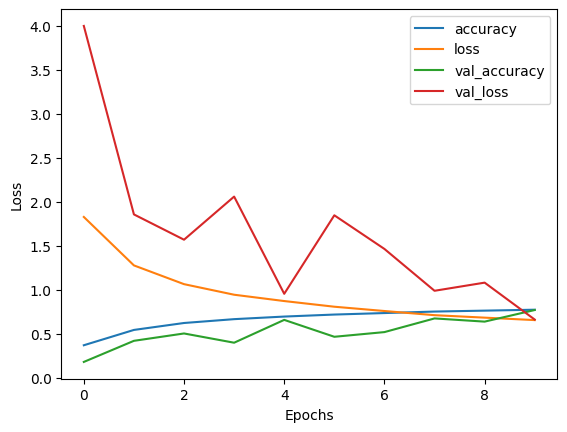

In [30]:
pd.DataFrame(History.history).plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

The training accuracy and validation accuracy are very close, indicating that the model is not overfitting. This is a good sign of generalization.

Validation loss is decreasing over epochs, and our training loss is not much lower than validation loss, also implies that our model is relatively not overfitting.

### 4. Summary

In this notebook, we input the CIFAR-10 images datasets from Kaggle competitions.

There are few steps and some finding:

1. Load and split preprocessed data

We split it into training and testing set. Training set has three columns, ids, images and labels, where testing set has two columns, ids and images. Overall, we have 50000 training samples and 5000 testing samples.

Then I normalized the data by dividing values by 255, which will normalizing the data between 0-1. And since our images set has 10 classes, so we can use one-hot encoded to label it. 

Lastly, there are examples of visualising the images set.

2. Use CNN for train and test a model

In this section, we build a CNN model to train and test. 

In total, We will have 6 CNN layers, 3 maxpool layer, 7 Batch Normalization, 4 Dropout, 1 Flatten and 2 Dense. So that we have enough layers with more filters, regularization, and ways to reduce overfitting.

From the last Epoch, we have 77.5% of Accuracy, 0.6535 of loss, 77.19% of validation accuracy and 0.6634 of validation loss.

3. Evaluate the model

In this section, we found that we have 79.02% validation accuracy with 0.6110 validation loss. 

This means that the model correctly predicted the labels of the validation set 79.02% of the time, the model is performing reasonably well, but there may still be room for improvement.

Loss is a measure of how well the model’s predictions match the true labels. A validation loss of 0.6110 is relatively low.

The training accuracy and validation accuracy are very close, indicating that the model is not overfitting. This is a good sign of generalization.

Validation loss is decreasing over epochs, and our training loss is not much lower than validation loss, also implies that our model is relatively not overfitting.

Next Steps: There are also other ways to explore and increase the performence of our model.

* Hyperparameter Tuning, we can explore different learning rates, batch sizes, number of epochs, and other hyperparameters to see if you can improve the model's performance.
* Build the model, we can explore different combination of model, such as adding more layers, changing the number of neurons in layers etc.
* Further evaluation, if we have testing labels, we could also consider metrics like precision, recall, and F1-score for a more comprehensive evaluation.
* Step by step building the model, we can build our model next time step by step, from only adding a few layers, to add drop out, batch normalization and data augmentation etc, so that we can see a more clear evolve and how the model performence changes.